In [9]:
%load_ext autoreload
%autoreload 2
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 140 ms (started: 2023-06-01 19:30:14 -04:00)


In [10]:
%reload_ext dotenv

%dotenv ../../env/.env

import warnings
from pandas import Timedelta
# from optiml.utils import sf
import time
from optiml.utils.sf import logger, sql_to_df, run_sql, conn, session
import pandas as pd
warnings.filterwarnings('ignore')

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 80.2 ms (started: 2023-06-01 19:30:14 -04:00)


In [5]:
# warehouse_id = 101
# ts = '2023-01-09 12:00:00.000 -0800'

wh = 97
ts = '2022-12-13 14:00:00.000 -0800'

# warehouse_id = 97
# # ts = '2023-01-09 12:00:00.000 -0800'
# ts = '2022-11-08 13:00:00.000 -0800'
# # 2022-11-08 13:29:39.020 -0800
# wh = 1019
run_sql(f"set ts = '{ts}'")
run_sql(f"set wh = '{wh}'")
# set ts = '2023-01-09 12:00:00.000 -0800';
# set wh = 101;

# 97	2022-12-13 14:00:00.000 -0800

queries = f"""
select *
from query_history_narrowed
where warehouse_id = $wh
and (start_time between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts)
or end_time between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts));

"""

events = f"""
select *
from stg_warehouse_events_history
where warehouse_id = $wh
and timestamp between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts);
"""

warehouse_eras = f"""

select *
from warehouse_era
where warehouse_id = $wh
and (era_start between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts)
or era_end between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts));

"""

cluster_query_eras = f"""
select *
from cluster_query_era
where warehouse_id:warehouse_id::number = $wh
and (era_start between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts)
or era_end between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts));
"""

spend = f"""
select *
from warehouse_metering_history_enriched
where warehouse_id = $wh
and (start_time between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts)
or end_time between dateadd(hour, -1, $ts) and dateadd(hour, 1, $ts));
"""

whe = sql_to_df(events)
cqe = sql_to_df(cluster_query_eras)
wheras = sql_to_df(warehouse_eras)
spend = sql_to_df(spend)

time: 6.37 s (started: 2023-05-23 20:56:35 -04:00)


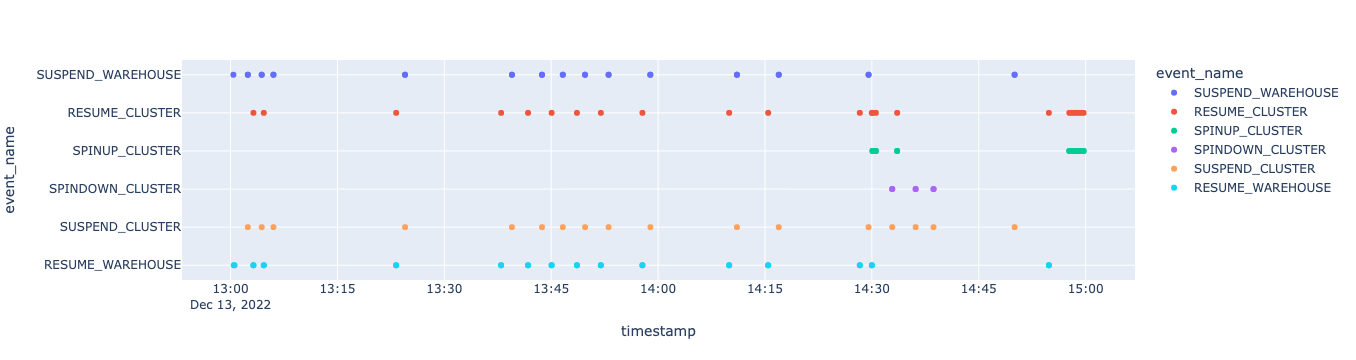

time: 82.1 ms (started: 2023-05-23 20:56:42 -04:00)


In [6]:
import plotly.express as px
fig = px.scatter(whe.sort_values('warehouse_name'), x="timestamp", y="event_name", color='event_name')
fig.show()

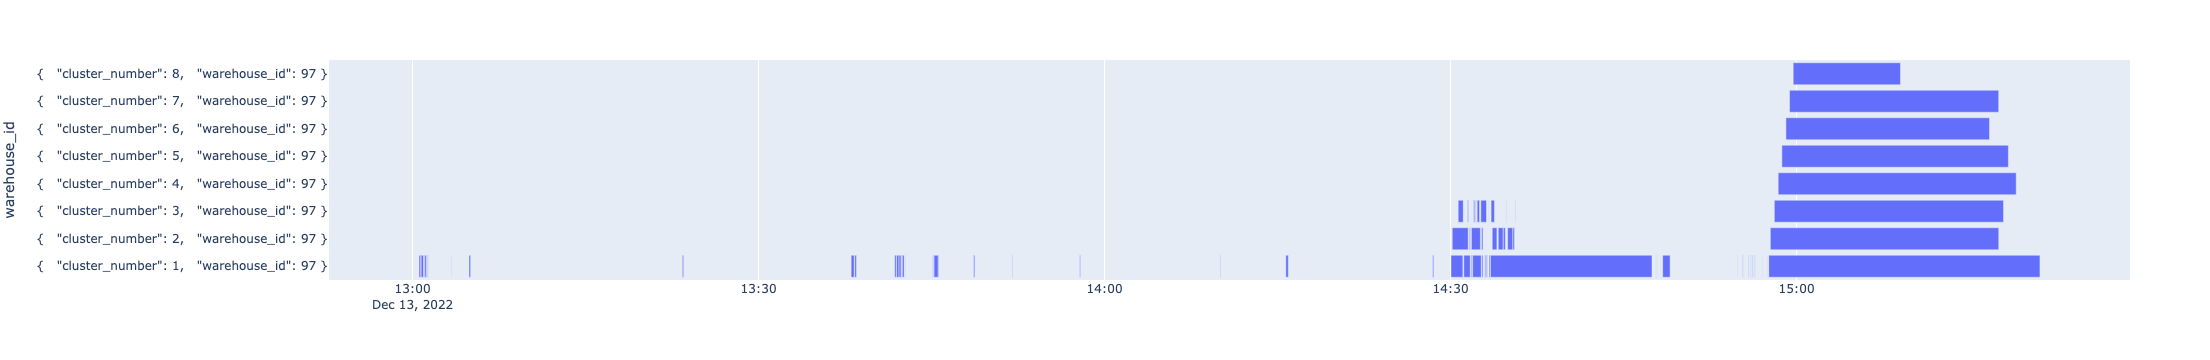

time: 80.1 ms (started: 2023-05-23 20:56:56 -04:00)


In [7]:
import plotly.express as px
fig = px.timeline(cqe.sort_values('warehouse_id'), y='warehouse_id', x_start="era_start", x_end="era_end")
# fig.update_layout(
#     xaxis_range=[cqe.era_start.min(), cqe.era_end.max()]  # Specify your desired minimum and maximum range
# )
fig.show()

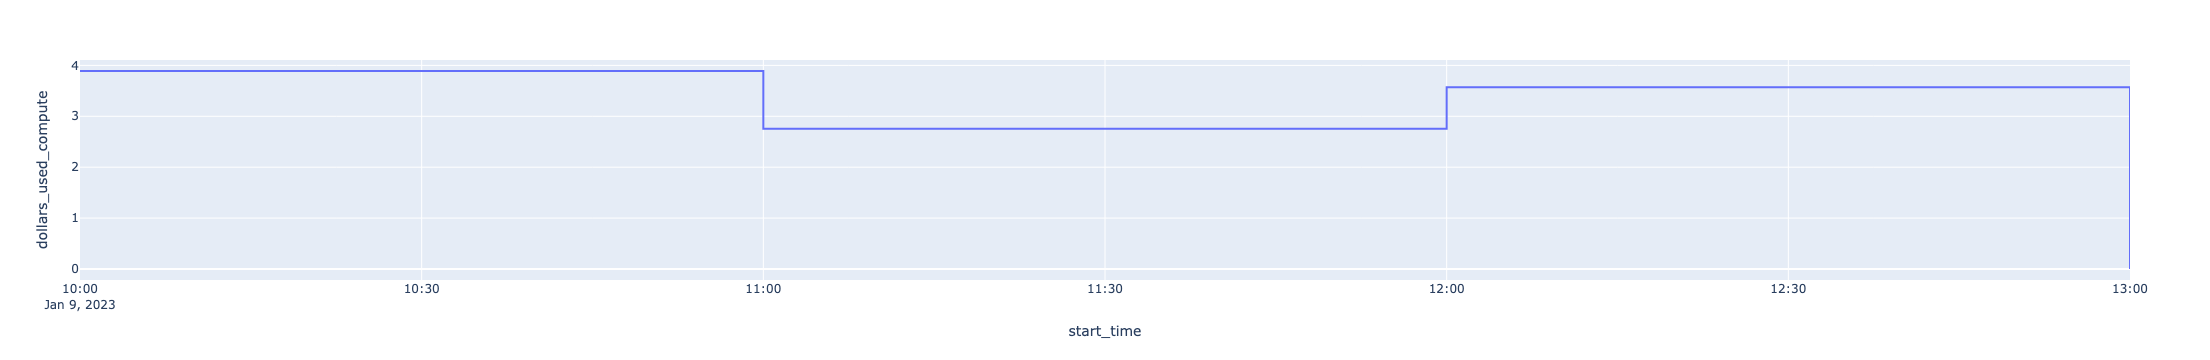

time: 37.5 ms (started: 2023-05-22 20:19:33 -04:00)


In [25]:
spend

fig = px.line(spend, x = 'start_time', y='dollars_used_compute', line_shape='hv')
fig.show()

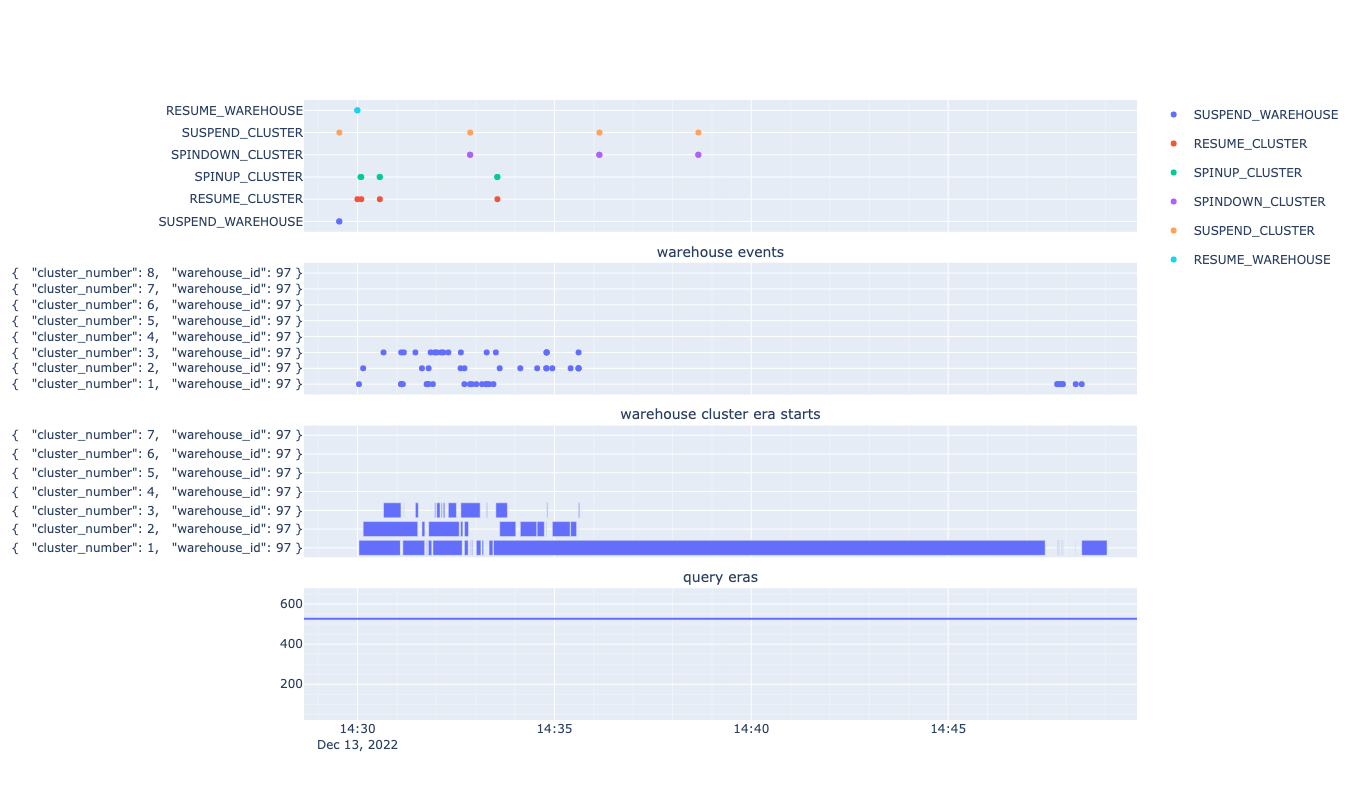

NameError: name 'whm' is not defined

time: 3.01 s (started: 2023-05-23 20:57:37 -04:00)


In [8]:
from plotly.subplots import make_subplots

# qdf['warehouse_query'] = qdf.warehouse_name + " : " + qdf.query_id

figures = [
px.scatter(whe.sort_values('warehouse_name'), x="timestamp", y="event_name", color='event_name'),
px.scatter(cqe.sort_values('warehouse_id'), x="era_start", y="warehouse_id"),
px.timeline(cqe.sort_values('warehouse_id'), y='warehouse_id', x_start="era_start", x_end="era_end"),
px.line(spend, x = 'start_time', y='dollars_used_compute', line_shape='hv')
    ]

fig = make_subplots(rows=len(figures), cols=1, shared_xaxes=True, vertical_spacing=0.05) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

fig.update_xaxes(title_text="warehouse events", row=1, col=1)
fig.update_xaxes(title_text="warehouse cluster era starts", row=2, col=1)
fig.update_xaxes(title_text="query eras", row=3, col=1)

fig.update_xaxes(showgrid=True,minor=dict(showgrid=True))
fig.update_yaxes(showgrid=True,minor=dict(showgrid=True))
fig.update_xaxes(autorange=True)
fig.update_layout(
    height=800,
)
fig.update_xaxes(type='date', autorange=True)

# fig.update_layout(
#     xaxis_range=[cqe.era_start.min(), cqe.era_end.max()]  # Specify your desired minimum and maximum range
# )
fig.show()

fig = px.bar(whm[whm.warehouse_name != 'OPS'], y='warehouse_name', x = ['credits_used_compute'], orientation = 'h', title='credits x warehouse')
fig.show()
fig = px.bar(whm, y='warehouse_name', x = ['credits_used_compute', 'credits_used_cloud_services'], orientation = 'h')
fig.show()

In [ ]:
# todo: 
# - show expected spend from cluster active eras
# - show spend on query time
# - show cluster active eras (can be trusted if expected spend ~ real spend)
# - show stats per cluster/warehouse-second (num queries running, num queued, total load, warehouse active or not, cumulative seconds active, cumulative billed secs)